In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
%cd /content/drive/MyDrive/apple_case_study

/content/drive/MyDrive/apple_case_study


In [22]:
!ls

apple_case_study.ipynb	models	squares


In [23]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [29]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2
data_dir = 'squares/squares/'

train_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            # transforms.RandomHorizontalFlip(), # randomly flip and rotate
            # transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
          ])
val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            # transforms.RandomHorizontalFlip(), # randomly flip and rotate
            # transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
          ])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/val', transform=val_transforms)

In [30]:
# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])


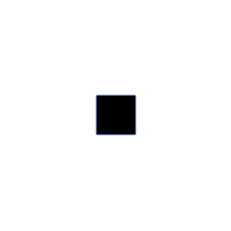

In [31]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax
# Run this to test your data loader
train_images, train_labels = next(iter(train_dataloader))
print(train_images.shape)
imshow(train_images[0], normalize=False)

In [32]:

from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutions
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.conv4 = nn.Conv2d(64,128,3,padding=1)
        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        # Max-pool
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(256*7*7,1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 3)
        #self.fc4 = nn.Linear(1024, 512)
        #self.fc5 = nn.Linear(512, 2)
        # Dropout module with 0.3 drop probability
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # make sure input tensor is flattened
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1,256*7*7)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        #x = self.dropout(F.relu(self.fc3(x)))
        #x = self.dropout(F.relu(self.fc4(x)))
        # output so no dropout here
        x = F.log_softmax(self.fc3(x),dim=1)

        return x
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:

print('loading...')
epochs = 15
steps = 0

train_losses, valid_losses = [], []
valid_loss_min = np.Inf # set initial "min" to infinity
for e in range(epochs):
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    for images, labels in train_dataloader:
        model.train() 
        optimizer.zero_grad()
        
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        #for calculating the accuracy of training set
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
    
        
        
        # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval() 
        for data, target in valid_loader:
             # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # update running validation loss 
            valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}\tTrain Accuracy: {:.3f} \tValidation Loss: {:.6f}'.format(
            e+1, 
            train_loss,
            train_accuracy/len(train_dataloader),
            valid_loss
            ))
    model.train() 
            # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
        torch.save(model.state_dict(), 'models/model1.pt')
        valid_loss_min = valid_loss

loading...
Epoch: 1 	Training Loss: 223.224398	Train Accuracy: 0.545 	Validation Loss: 1.110821
Validation loss decreased (inf --> 1.110821).  Saving model ...
Epoch: 2 	Training Loss: 1.183338	Train Accuracy: 0.277 	Validation Loss: 1.100206
Validation loss decreased (1.110821 --> 1.100206).  Saving model ...
Epoch: 3 	Training Loss: 1.145225	Train Accuracy: 0.059 	Validation Loss: 1.099197
Validation loss decreased (1.100206 --> 1.099197).  Saving model ...
Epoch: 4 	Training Loss: 1.117026	Train Accuracy: 0.035 	Validation Loss: 1.098697
Validation loss decreased (1.099197 --> 1.098697).  Saving model ...
Epoch: 5 	Training Loss: 1.105090	Train Accuracy: 0.188 	Validation Loss: 1.098683
Validation loss decreased (1.098697 --> 1.098683).  Saving model ...
Epoch: 6 	Training Loss: 1.103937	Train Accuracy: 0.138 	Validation Loss: 1.098685
Epoch: 7 	Training Loss: 1.103660	Train Accuracy: 0.102 	Validation Loss: 1.098681
Validation loss decreased (1.098683 --> 1.098681).  Saving model .

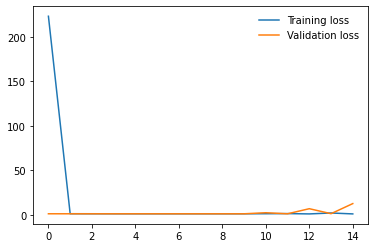

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [35]:
model.load_state_dict(torch.load('models/model1.pt'))

<All keys matched successfully>

In [40]:
val_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update val loss 
    val_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate val accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
val_loss = val_loss/len(valid_loader.dataset)
print('Val Loss: {:.6f}\n'.format(val_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Val Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Val Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\Val Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Val Loss: 1.098406

Val Accuracy of     0:  0% ( 0/500)
Val Accuracy of     1:  5% (27/500)
Val Accuracy of     2: 100% (500/500)
\Val Accuracy (Overall): 35% (527/1500)
